# Inventory Optimization 

## **Project Overview**
This project focuses on **supply chain optimization** using the **Stable Baselines3 SAC (Soft Actor-Critic)** algorithm which is used to train an RL agent to make optimal decisions. The goal is to optimize inventory management in a multi-echelon supply chain environment, which includes:

1. **Factory**: Produces goods at a constant cost per unit.
2. **Factory Warehouse**: Stores goods with a maximum capacity and incurs storage costs.
3. **Distribution Warehouses**: Multiple warehouses that receive goods from the factory warehouse, store them, and fulfill retail demand.

The environment is complex, with factors such as:
- **Seasonal demand changes**: Demand varies over time and across warehouses.
- **Transportation costs**: Shipping goods from the factory warehouse to distribution warehouses incurs costs.
- **Storage costs**: Holding inventory at any location has associated costs.
- **Penalties for unfulfilled demand**: If demand exceeds stock levels, penalties are incurred.

The **reward function** balances **revenue**, **production costs**, **storage costs**, **transportation costs**, and **penalty costs**. The **state vector** includes stock levels and historical demand data, while the **action vector** consists of production and shipping decisions.

The ultimate objective is to train a DRL agent to make optimal decisions that maximize profit while minimizing costs and penalties.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# For displaying outputs in Jupyter notebooks
from IPython.display import display

# For specialized container datatypes
import collections

# For customizing matplotlib styles
from qbstyles import mpl_style
mpl_style(dark=False)

# Supply Chain Environment Implementation

This code defines a supply chain environment for reinforcement learning. It includes:
- **State Class**: Tracks factory and warehouse stock levels, demand history, and time.
- **Action Class**: Represents production levels and shipping decisions.
- **SupplyChainEnvironment Class**: Simulates the supply chain, including demand generation, reward calculation, and state transitions.

The environment models a factory, warehouses, and dynamic demand, with costs for production, storage, transportation, and penalties for unfulfilled demand.

### Assumptions
1. **Episode Duration**: Each episode lasts 26 time steps.
2. **Number of Warehouses: There are 5 warehouses in the supply chain.
3. **Maximum Demand**: The maximum demand at any warehouse is 10 units.
4. **Random Demand Variation**: Demand can vary randomly by up to 3 units.
5. **Unit Price**: Each unit sold generates $100 in revenue.
6. **Unit Cost**: Producing one unit costs $40.

### **Demand Function**

The `demand` function generates the demand for a specific warehouse `j` at time step `t`. The demand is modeled as a combination of a seasonal pattern and random variation.

The demand function is defined as:

\[
d(j, t) = \text{round}\left( \frac{d_{\text{max}}}{2} + \frac{d_{\text{max}}}{2} \cdot \sin\left( \frac{2\pi (t + 2j)}{T} \cdot 2 \right) + \text{rand}(0, d_{\text{var}}) \right)
\]

Where:
- \( d(j, t) \): Demand at warehouse \( j \) at time \( t \).
- \( d_{\text{max}} \): Maximum demand per warehouse.
- \( T \): Total duration of an episode (26 time steps).
- \( \text{rand}(0, d_{\text{var}}) \): Random integer between 0 and \( d_{\text{var}} \).

### **Explanation**
1. **Seasonal Pattern**: The sine function creates a periodic demand pattern, simulating seasonal variations.
   - \( \frac{2\pi (t + 2j)}{T} \cdot 2 \): Adjusts the frequency and phase of the sine wave based on time \( t \) and warehouse \( j \).
2. **Random Variation**: Adds randomness to the demand to simulate real-world unpredictability.
3. **Rounding**: Ensures the demand is an integer value.

---



In [2]:
# Represents the state of the supply chain at any given time.
class State(object):
    def __init__(self, warehouse_num, T, demand_history, t=0):
        self.warehouse_num = warehouse_num  # Number of warehouses in the supply chain
        self.factory_stock = 0  # Current stock level at the factory
        self.warehouse_stock = np.repeat(0, warehouse_num)  # Stock levels at each warehouse, initialized to 0
        self.demand_history = demand_history  # Historical demand data for each warehouse (simulated)
        self.T = T  # Total duration of an episode (time steps)
        self.t = t  # Current time step

    #Converts the state into a numerical array for the reinforcement learning agent to process.
    #Combines factory stock, warehouse stock, demand history, and current time into a single array.
    def to_array(self):
        return np.concatenate( ([self.factory_stock], self.warehouse_stock, np.hstack(self.demand_history), [self.t]) )

    #Provides a simplified array of stock levels (factory + warehouses).
    def stock_levels(self):
        return np.concatenate( ([self.factory_stock], self.warehouse_stock) )

#Represents the actions the agent can take (production and shipping decisions).
class Action(object):
    def __init__(self, warehouse_num):
        self.production_level = 0
        self.shippings_to_warehouses = np.zeros(warehouse_num)

# Simulates the supply chain environment, including demand, costs, and state transitions.
class SupplyChainEnvironment(object):
    def __init__(self):
        self.T = 26               # Episode duration (26 time steps)
        self.warehouse_num = 3    # Number of warehouses
        self.d_max = 5           # Maximum demand per warehouse
        self.d_var = 2            # Random demand variation 
        self.unit_price = 100     # Unit price in dollars
        self.unit_cost = 40       # Unit cost in dollars

        # Storage capacities for factory and warehouses
        self.storage_capacities = np.fromfunction(lambda j: 10*(j+1), (self.warehouse_num + 1,), dtype=int)

        # Storage costs for factory and warehouses
        self.storage_costs = np.fromfunction(lambda j: 2*(j+1), (self.warehouse_num + 1,), dtype=int)           # storage costs at the factory and each warehouse, dollars per unit
        
        # Transportation costs to each warehouse
        self.transporation_costs = np.fromfunction(lambda j: 5*(j+1), (self.warehouse_num,), dtype=int)       # transportation costs for each warehouse, dollars per unit
        
         # Penalty for unfulfilled demand
        self.penalty_unit_cost = self.unit_price
        
        self.reset()

    # Resets the environment to its initial state.
    # Required for starting new episodes during training.
    def reset(self, demand_history_len = 4): # Stores the last 4 demand values for each warehouse.
        self.demand_history = collections.deque(maxlen = demand_history_len)
        for i in range(demand_history_len):
            self.demand_history.append( np.zeros(self.warehouse_num) )
        self.t = 0

    # Generates demand for a specific warehouse at a specific time.
    # Simulates realistic, time-varying demand.
    # Using a sine wave to model seasonal demand, with random variation.
    def demand(self, j, t):
        return np.round(self.d_max/2 + self.d_max/2*np.sin(2*np.pi*(t + 2*j)/self.T*2) + np.random.randint(0, self.d_var))

    # Required at the start of each episode.
    def initial_state(self):
        return State(self.warehouse_num, self.T, list(self.demand_history))

    # Simulates one time step in the environment.
    def step(self, state, action):
        demands = np.fromfunction(lambda j: self.demand(j+1, self.t), (self.warehouse_num,), dtype=int)
    
        # calculating the reward (profit)
        total_revenue = self.unit_price * np.sum(demands)
        total_production_cost = self.unit_cost * action.production_level
        total_storage_cost = np.dot( self.storage_costs, np.maximum(state.stock_levels(), np.zeros(self.warehouse_num + 1)) )
        total_penalty_cost = - self.penalty_unit_cost * ( np.sum( np.minimum(state.warehouse_stock, np.zeros(self.warehouse_num)) )  +  min(state.factory_stock, 0))
        total_transportation_cost = np.dot( self.transporation_costs, action.shippings_to_warehouses )
        reward = total_revenue - total_production_cost - total_storage_cost - total_penalty_cost - total_transportation_cost

        # calculating the next state
        next_state = State(self.warehouse_num, self.T, self.t)
        next_state.factory_stock = min(state.factory_stock + action.production_level - np.sum(action.shippings_to_warehouses), self.storage_capacities[0]) 
        for w in range(self.warehouse_num):
            next_state.warehouse_stock[w] = min(state.warehouse_stock[w] + action.shippings_to_warehouses[w] - demands[w], self.storage_capacities[w+1])    
        next_state.demand_history = list(self.demand_history)

        self.t += 1
        self.demand_history.append(demands)

        return next_state, reward, self.t == self.T - 1

## **Visualizing Demand Functions for Warehouses**

This code block visualizes the demand patterns for each warehouse over the duration of an episode. The demand for each warehouse is generated using the `demand` function, which incorporates seasonal patterns and random variations.

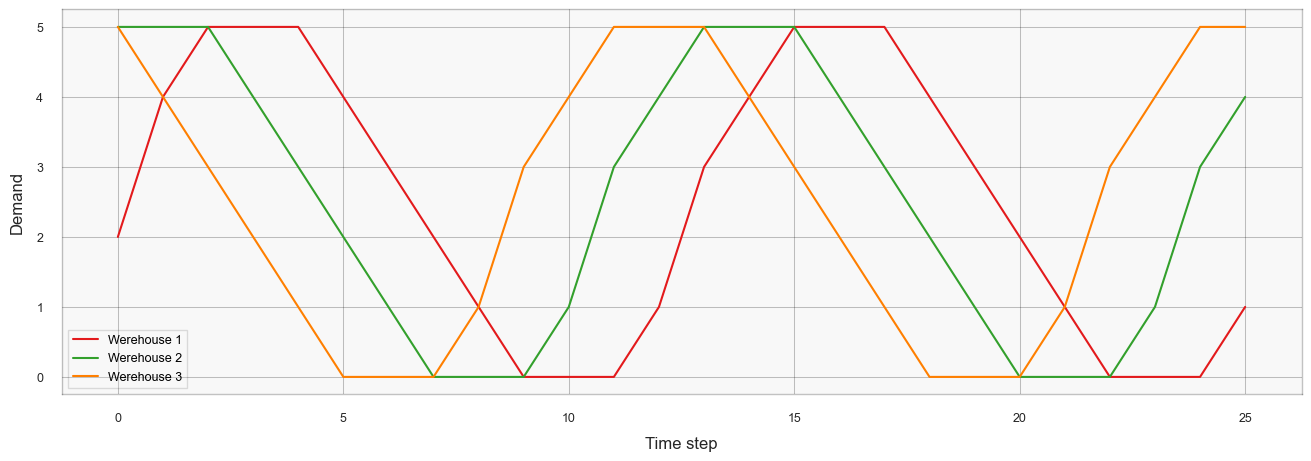

In [3]:
# visualize demand functions for warehouses

# Create an instance of the SupplyChainEnvironment
env = SupplyChainEnvironment() 

# Generate demand values for all warehouses over all time steps
demands = np.fromfunction(lambda j, t: env.demand(j, t), (env.warehouse_num, env.T), dtype=int)

plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Demand")
plt.plot(range(env.T), demands.T)
plt.legend([f'Werehouse {i+1}' for i in range(env.warehouse_num)])

## **Visualizing Supply Chain Metrics**

This code visualizes key metrics from a supply chain episode, including:
1. **Stock Levels**: Factory and warehouse stock levels over time.
2. **Actions**: Production levels and shipments to warehouses.
3. **Rewards**: Instantaneous and cumulative profit over time.

---

### **Key Features**
- **Metrics Visualized**:
  - Factory stock levels.
  - Warehouse stock levels.
  - Production levels.
  - Shipments to each warehouse.
  - Instantaneous profit.
  - Cumulative profit.
- **Subplots**: Each metric is displayed in a separate subplot for clarity.


In [4]:
# Function to prepare a subplot for a specific metric
def prepare_metric_plot(plots_n, n, ylabel):
    plt.subplot(plots_n, 1, n)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)

# visualizing one episode - stock levels, production and reorderign actions, and rewards
def visualize_transitions(transitions):
    # Unpack transitions into state, action, and reward traces
    state_trace, action_trace, reward_trace = (transitions.T[0], transitions.T[1], transitions.T[2])
    plots_n = 10
    mpl.rcParams['lines.linewidth'] = 2    
    print(f"Return is {sum(reward_trace)}")

    fig = plt.figure(figsize=(8, 12))

    # Plot factory stock levels
    prepare_metric_plot(plots_n, 1, "Stock,\n Factory")
    plt.plot(range(env.T), list(map(lambda s: s.factory_stock, state_trace)), c='purple', alpha=0.5)

    # Plot warehouse stock levels
    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 2 + w, f"Stock,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda s: s.warehouse_stock[w], state_trace)), c='purple', alpha=0.5)
    
     # Plot production levels
    prepare_metric_plot(plots_n, 5, "Production")
    plt.plot(range(env.T), list(map(lambda a: a.production_level, action_trace)), c='blue', alpha=0.5)

    # Plot shipments to each warehouse
    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 6 + w, f"Shipment,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda a: a.shippings_to_warehouses[w], action_trace)), c='blue', alpha=0.5)
    
    # Plot instantaneous profit
    prepare_metric_plot(plots_n, 9, "Profit")
    plt.plot(range(env.T), reward_trace, c='red', alpha=0.9, linewidth=2)

    # Plot cumulative profit
    plt.subplot(plots_n, 1, 10)
    plt.ylabel("Cumulative\nprofit")
    plt.ylim(0, 10000)
    plt.plot(range(env.T), np.cumsum(reward_trace), c='red', alpha=0.9, linewidth=2)
    plt.xlabel("Time step")

## **Baseline (s, Q)-Policy Implementation**

This code implements and evaluates a baseline inventory management policy known as the **(s, Q)-policy**. The policy is defined as:
- **Reorder Point (s)**: When inventory drops below this level, an order is placed.
- **Order Quantity (Q)**: The fixed amount to order when the reorder point is reached.

The policy is applied to both the factory and warehouses in the supply chain. The code also includes functions to simulate episodes and evaluate the policy over multiple episodes.

---

### **Key Features**
- **Policy Definition**:
  - Factory and warehouses have separate reorder points (`safety_stock`) and order quantities (`reorder_amount`).
- **Action Selection**:
  - Orders are placed when inventory drops below the reorder point.
  - Factory production is triggered based on factory stock levels.
- **Simulation**:
  - Simulates episodes using the policy.
  - Evaluates the policy by calculating cumulative rewards over multiple episodes.

In [5]:
# Define the (s, Q)-policy for inventory management
class SQPolicy(object):
    def __init__(self, factory_safety_stock, factory_reorder_amount, safety_stock, reorder_amount): # Initialize policy parameters
        self.factory_safety_stock = factory_safety_stock # Reorder point for the factory
        self.factory_reorder_amount = factory_reorder_amount # Order quantity for the factory
        self.safety_stock = safety_stock # Reorder points for each warehouse
        self.reorder_amount = reorder_amount # Order quantities for each warehouse

    def select_action(self, state):
        action = Action(state.warehouse_num) # Create an action object

        # Check warehouse stock levels and place orders if below reorder points
        for w in range(state.warehouse_num):
            if state.warehouse_stock[w] < self.safety_stock[w]:
                action.shippings_to_warehouses[w] = self.reorder_amount[w]
    
        # Check factory stock levels and trigger production if below reorder point
        if state.factory_stock - np.sum(action.shippings_to_warehouses) < self.factory_safety_stock: 
            action.production_level = self.factory_reorder_amount
            
        else: 
            action.production_level = 0 # No production if stock is sufficient
        return action
    
# Simulate a single episode using the policy
def simulate_episode(env, policy):
    state = env.initial_state() # Initialize the environment state
    transitions = [] # Store state, action, and reward for each time step
    
    # Simulate the episode for T time steps
    for t in range(env.T):
        action = policy.select_action(state) # Select action based on the current state and policy
        state, reward, _ = env.step(state, action) # Execute the action and transition to the next state
        transitions.append([state, action, reward]) # Record the transition
    return transitions

# Evaluate the policy over multiple episodes
def simulate(env, policy, num_episodes):
    returns_trace = [] # Store cumulative rewards for each episode
    
    # Simulate the policy for the specified number of episodes
    for episode in range(num_episodes):
        env.reset() # Reset the environment for a new episode
        
        # Simulate the episode and calculate the cumulative reward
        returns_trace.append( sum(np.array(simulate_episode(env, policy)).T[2]) )
        
    return returns_trace

## **Hyperparameter Optimization with Optuna**

This code uses **Optuna**, a hyperparameter optimization framework, to find the best parameters for the (s, Q)-policy. The goal is to maximize the average cumulative reward (profit) over multiple episodes by tuning the reorder points (`s`) and order quantities (`Q`) for the factory and warehouses.

---

### **Key Features**
- **Objective Function**:
  - Defines the parameters to optimize (`factory_s`, `factory_Q`, `w1_s`, `w1_Q`, etc.).
  - Creates an (s, Q)-policy with the suggested parameters.
  - Evaluates the policy by simulating 30 episodes and returning the average reward.
- **Optuna Study**:
  - Creates a study to maximize the objective function.
  - Runs 200 trials to explore the parameter space.
- **Output**:
  - Prints the best parameters and the corresponding best value (average reward).

In [6]:
import optuna # Hyperparameter optimization library

# Define the objective function for Optuna
def objective(trial): 

    # Suggest values for the factory's reorder point (s) and order quantity (Q)
    factory_s = trial.suggest_float("factory_s", 0.0, 30.0) # Reorder point for the factory
    factory_Q = trial.suggest_float("factory_Q", 0.0, 30.0) # Order quantity for the factory
    
    # Suggest values for the warehouses' reorder points (s) and order quantities (Q)
    w1_s = trial.suggest_float("w1_s", 0.0, 20.0) # Reorder point for warehouse 1
    w1_Q = trial.suggest_float("w1_Q", 0.0, 20.0) # Order quantity for warehouse 1
    w2_s = trial.suggest_float("w2_s", 0.0, 20.0)
    w2_Q = trial.suggest_float("w2_Q", 0.0, 20.0)
    w3_s = trial.suggest_float("w3_s", 0.0, 20.0)
    w3_Q = trial.suggest_float("w3_Q", 0.0, 20.0)

    # Create an (s, Q)-policy with the suggested parameters
    policy = SQPolicy(
        factory_s, factory_Q,
        [w1_s, w2_s, w3_s],
        [w1_Q, w2_Q, w3_Q]
    )
    
    # Evaluate the policy by simulating 30 episodes and returning the average reward
    return np.mean(simulate(env, policy, num_episodes=30))

# Create an Optuna study to maximize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

# Print best parameters
print("Best parameters:", study.best_params)
print("Best value:", study.best_value)


[I 2025-03-05 16:32:34,096] A new study created in memory with name: no-name-97f6ba8c-0353-494a-b983-d73374db5368
[I 2025-03-05 16:32:34,136] Trial 0 finished with value: -30335.78844482997 and parameters: {'factory_s': 21.993285914197976, 'factory_Q': 11.294684384518693, 'w1_s': 1.1373982985043463, 'w1_Q': 5.605471824168832, 'w2_s': 11.3489856569124, 'w2_Q': 18.171680328590366, 'w3_s': 12.21774030319655, 'w3_Q': 10.826549336906412}. Best is trial 0 with value: -30335.78844482997.
[I 2025-03-05 16:32:34,180] Trial 1 finished with value: -139472.84505516052 and parameters: {'factory_s': 19.504397839107607, 'factory_Q': 8.299246788850084, 'w1_s': 11.977406401693864, 'w1_Q': 9.66083733966226, 'w2_s': 9.119962015901034, 'w2_Q': 7.472207645595446, 'w3_s': 11.26032810633128, 'w3_Q': 19.568760080918395}. Best is trial 0 with value: -30335.78844482997.
[I 2025-03-05 16:32:34,224] Trial 2 finished with value: -14822.856701249593 and parameters: {'factory_s': 13.255085413831093, 'factory_Q': 17.

Best parameters: {'factory_s': 4.615627409152745, 'factory_Q': 11.9873466759634, 'w1_s': 3.189631566878153, 'w1_Q': 5.320628888356921, 'w2_s': 2.7151736612374107, 'w2_Q': 4.771265051349842, 'w3_s': 1.3054375389590414, 'w3_Q': 5.195107532990962}
Best value: 6348.686174479368


## **Evaluating and Visualizing the Winning (s, Q)-Policy**

This code evaluates and visualizes the performance of the winning (s, Q)-policy, which was determined through hyperparameter optimization. The evaluation involves:
1. **Accurate Evaluation**:
   - Simulates 100 episodes to calculate the mean and standard deviation of the cumulative rewards.
2. **Visualization**:
   - Plots the cumulative rewards over the 100 episodes.
   - Traces the policy's behavior in a single episode, visualizing stock levels, actions, and rewards.

Reward: mean 7282.44, standard deviation 757.4031333444561
Return is 9482.0


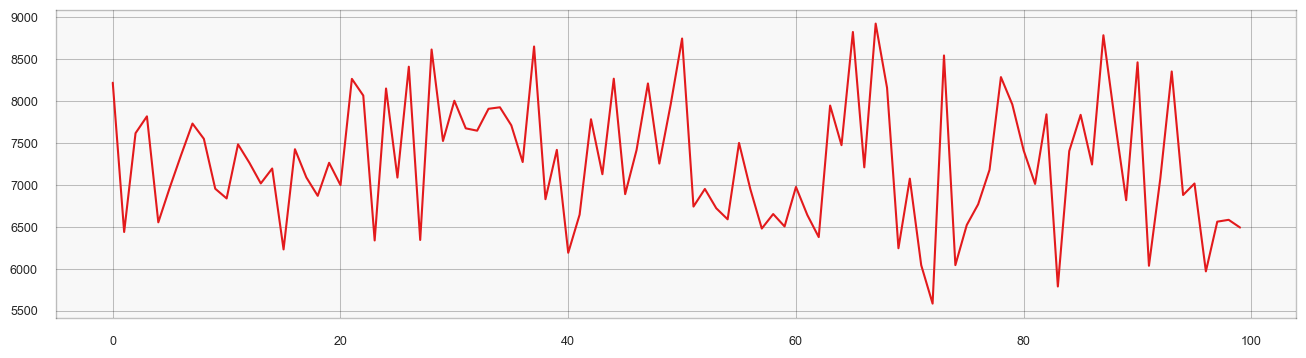

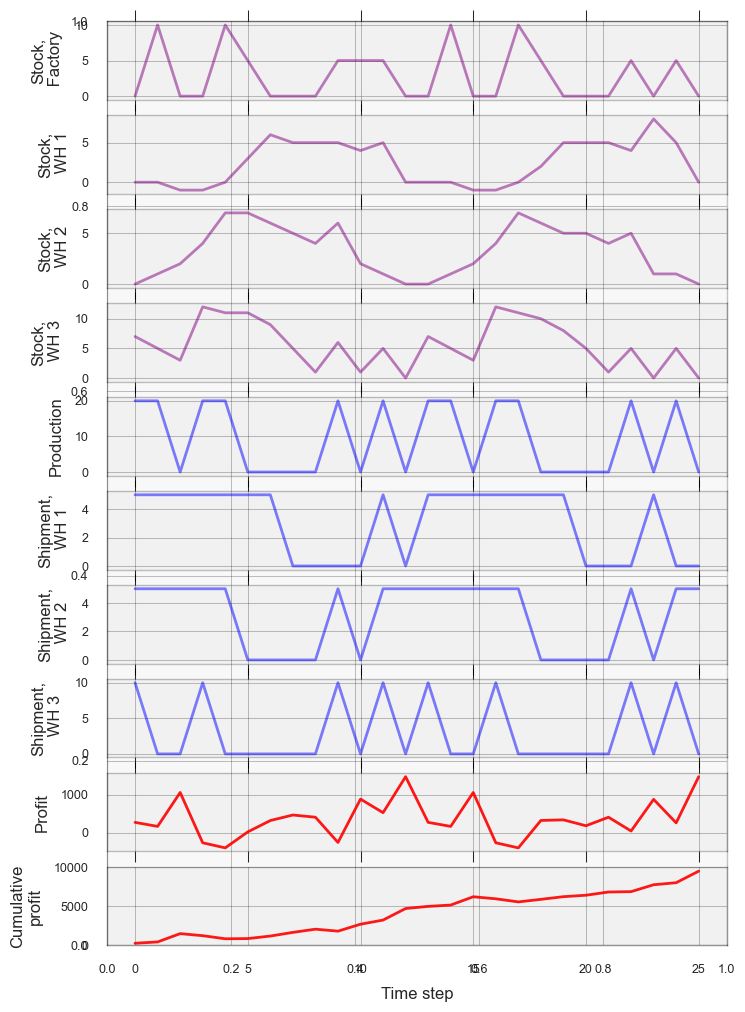

In [7]:
# evaluating the winning (s,Q) policy more accurately
env = SupplyChainEnvironment()

# Define the winning policy
policy_sQ = SQPolicy(0.0, 20.0, [5, 5, 5], [5, 5,10])
return_trace = simulate(env, policy_sQ, num_episodes = 100) # 100 episodes

plt.figure(figsize=(16, 4))
plt.plot(range(len(return_trace)), return_trace)
print(f"Reward: mean {np.mean(return_trace)}, standard deviation {np.std(return_trace)}")

# tracing the winning (s,Q) policy in a single episode
env = SupplyChainEnvironment() # Reset the environment
transitions_sQ = simulate_episode(env, policy_sQ) # Simulate a single episode
visualize_transitions(np.array(transitions_sQ)) # Visualize the episode's transitions

## **Grid Search for (s, Q)-Policy Optimization**

This code performs a **grid search** to find the best parameters for the (s, Q)-policy. It evaluates all possible combinations of reorder points (`s`) and order quantities (`Q`) for the factory and warehouses, using a predefined parameter grid. The goal is to identify the parameter combination that maximizes the average cumulative reward (profit) over 10 episodes.

---

### **Key Features**
- **Parameter Grid**:
  - Defines ranges for factory and warehouse parameters (`factory_s`, `factory_Q`, `w1_s`, `w1_Q`, etc.).
  - Uses `sklearn.model_selection.ParameterGrid` to generate all possible combinations.
- **Grid Search**:
  - Iterates through each parameter combination.
  - Evaluates the policy by simulating 10 episodes and calculating the average reward.
  - Tracks the best-performing parameter combination.
- **Progress Tracking**:
  - Prints the best reward found every 100 configurations.

In [8]:
from sklearn.model_selection import ParameterGrid

p_grid1 = [5, 10, 20] # Possible values for factory parameters
p_grid2 = [5, 10, 20] # Possible values for warehouse parameters
param_grid = {
    'factory_s': p_grid1, 
    'factory_Q': p_grid1,
    'w1_s': p_grid2, # Warehouse 1 reorder point
    'w2_s': p_grid2,
    'w3_s': p_grid2,
    'w1_Q': p_grid2, # Warehouse 1 order quantity
    'w2_Q': p_grid2,
    'w3_Q': p_grid2,
    }

env = SupplyChainEnvironment() # Create an instance of the supply chain environment
grid = ParameterGrid(param_grid) # Generate all parameter combinations using ParameterGrid

# Initialize variables to track the best configuration
i = 0 # Counter for the number of configurations evaluated
best_return = float('-inf') # Track the highest average reward
best_params = None  # Track the best parameter combination

# Iterate through each parameter combination
for p in grid:
    policy = SQPolicy(
        p['factory_s'], p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],  # Warehouse reorder points
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]   # Warehouse order quantiti
    )

    # Evaluate the policy by simulating 10 episodes and calculating the average reward
    m_return = np.mean(simulate(env, policy, num_episodes = 10))

    # Update the best configuration if the current one performs better
    if m_return > best_return:
        best_return = m_return
        best_params = p

     # Print progress every 100 configurations
    if i % 100 == 0:
        print(f"Configuration #{i} -- {best_return}")
    i += 1

Configuration #0 -- -141546.0
Configuration #100 -- -141546.0
Configuration #200 -- -141546.0
Configuration #300 -- -141546.0
Configuration #400 -- -141546.0
Configuration #500 -- -141546.0
Configuration #600 -- -141546.0
Configuration #700 -- -141546.0
Configuration #800 -- -137662.4
Configuration #900 -- -137662.4
Configuration #1000 -- -137662.4
Configuration #1100 -- -137662.4
Configuration #1200 -- -137662.4
Configuration #1300 -- -137662.4
Configuration #1400 -- -137662.4
Configuration #1500 -- -137662.4
Configuration #1600 -- -137662.4
Configuration #1700 -- -137662.4
Configuration #1800 -- -137662.4
Configuration #1900 -- -137662.4
Configuration #2000 -- -137662.4
Configuration #2100 -- -137662.4
Configuration #2200 -- -4014.2
Configuration #2300 -- -4014.2
Configuration #2400 -- -4014.2
Configuration #2500 -- -4014.2
Configuration #2600 -- -4014.2
Configuration #2700 -- -4014.2
Configuration #2800 -- -4014.2
Configuration #2900 -- -4014.2
Configuration #3000 -- -2525.2
Configu

## **Supply Chain Optimization with Reinforcement Learning**

This code implements a **supply chain optimization** environment using **Reinforcement Learning (RL)**. The environment models a factory, warehouses, and dynamic demand, with the goal of maximizing profit while minimizing costs. The **Stable Baselines3 SAC (Soft Actor-Critic)** algorithm is used to train an RL agent to make optimal decisions.

---

### **Key Features**
1. **Supply Chain Environment**:
   - Models a factory, warehouses, and dynamic demand.
   - Includes costs for production, storage, transportation, and penalties for unfulfilled demand.
2. **Custom Gym Environment**:
   - Wraps the supply chain environment in a Gym-compatible interface for RL training.
3. **RL Training**:
   - Uses the **SAC algorithm** to train an agent to optimize supply chain decisions.
   - Saves the trained model for future use.

In [9]:
import gym  # OpenAI Gym for RL environments
from gym.spaces import Box  # For defining continuous action and observation spaces
from stable_baselines3 import SAC  # Soft Actor-Critic algorithm for RL
from stable_baselines3.common.env_checker import check_env  # For environment validation

# --- Existing supply chain classes ---

class State(object):
    def __init__(self, warehouse_num, T, demand_history, t=0):
        self.warehouse_num = warehouse_num
        self.factory_stock = 0
        self.warehouse_stock = np.repeat(0, warehouse_num)
        self.demand_history = demand_history
        self.T = T
        self.t = t

    # Convert the state to a numerical array for RL input
    def to_array(self):
        return np.concatenate(([self.factory_stock],
                               self.warehouse_stock,
                               np.hstack(self.demand_history),
                               [self.t]))

    def stock_levels(self):
        return np.concatenate(([self.factory_stock], self.warehouse_stock))


class Action(object):
    def __init__(self, warehouse_num):
        self.production_level = 0
        self.shippings_to_warehouses = np.zeros(warehouse_num)


class SupplyChainEnvironment(object):
    def __init__(self):
        self.T = 26               # Episode duration (26 time steps)
        self.warehouse_num = 3    # Number of warehouses
        self.d_max = 5           # Maximum demand per warehouse
        self.d_var = 2            # Random demand variation 
        self.unit_price = 100     # Unit price in dollars
        self.unit_cost = 40       # Unit cost in dollars
        self.storage_capacities = np.fromfunction(lambda j: 10*(j+1), (self.warehouse_num + 1,), dtype=int)
        self.storage_costs = np.fromfunction(lambda j: 2*(j+1), (self.warehouse_num + 1,), dtype=int)
        self.transporation_costs = np.fromfunction(lambda j: 5*(j+1), (self.warehouse_num,), dtype=int)
        self.penalty_unit_cost = self.unit_price
        self.reset()

    def reset(self, demand_history_len=4):
        import collections
        self.demand_history = collections.deque(maxlen=demand_history_len)

        # Fixed-size demand history
        for _ in range(demand_history_len):
            self.demand_history.append(np.zeros(self.warehouse_num))
        self.t = 0

    def demand(self, j, t):
        # Demand at time t at warehouse j 
        return np.round(self.d_max/2 + self.d_max/2 * np.sin(2*np.pi*(t+2*j)/self.T*2) 
                        + np.random.randint(0, self.d_var))

    def initial_state(self):
        # Create the initial state of the environment
        return State(self.warehouse_num, self.T, list(self.demand_history))

    def step(self, state, action):
        demands = np.fromfunction(lambda j: self.demand(j+1, self.t), (self.warehouse_num,), dtype=int)
    
        # Calculate reward (profit)
        total_revenue = self.unit_price * np.sum(demands)
        total_production_cost = self.unit_cost * action.production_level
        total_storage_cost = np.dot(self.storage_costs, np.maximum(state.stock_levels(), np.zeros(self.warehouse_num + 1)))
        total_penalty_cost = -self.penalty_unit_cost * ( np.sum(np.minimum(state.warehouse_stock, np.zeros(self.warehouse_num)))  
                                                       + min(state.factory_stock, 0))
        total_transportation_cost = np.dot(self.transporation_costs, action.shippings_to_warehouses)
        reward = total_revenue - total_production_cost - total_storage_cost - total_penalty_cost - total_transportation_cost

        # Update the state
        next_state = State(self.warehouse_num, self.T, self.t)
        next_state.factory_stock = min(state.factory_stock + action.production_level - np.sum(action.shippings_to_warehouses),
                                       self.storage_capacities[0])
        for w in range(self.warehouse_num):
            next_state.warehouse_stock[w] = min(state.warehouse_stock[w] + action.shippings_to_warehouses[w] - demands[w],
                                                 self.storage_capacities[w+1])
        next_state.demand_history = list(self.demand_history)
        self.t += 1
        self.demand_history.append(demands)
        done = (self.t == self.T - 1)
        return next_state, reward, done


# --- Custom Gym Environment Wrapper ---

class SimpleSupplyChainEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.env = SupplyChainEnvironment()
        self.action_space = Box(low=0.0, high=20.0, 
                                shape=(self.env.warehouse_num + 1,), dtype=np.float32)
        # Observation shape from initial state array.
        init_obs = self.env.initial_state().to_array()
        self.observation_space = Box(-10000, 10000, shape=init_obs.shape, dtype=np.float32)

    def reset(self):
        self.env.reset()
        state = self.env.initial_state()
        return state.to_array()

    def step(self, action):
        state = self.env.initial_state()
        action_obj = Action(self.env.warehouse_num)
        action_obj.production_level = action[0]
        action_obj.shippings_to_warehouses = action[1:]
        next_state, reward, done = self.env.step(state, action_obj)
        return next_state.to_array(), reward, done, {}


# Create and (optionally) check your environment.
env = SimpleSupplyChainEnv()
# Uncomment the next line to run a basic environment check:
# check_env(env, warn=True)

# --- Training with Stable Baselines3 SAC ---

# Initialize the SAC model
model = SAC(
    "MlpPolicy",  # Policy network architecture
    env,  # Environment to train on
    verbose=1,  # Print training progress
    gamma=0.95,  # Discount factor for future rewards
    learning_rate=0.001,  # Default is 0.0003. Higher is more unstable
    buffer_size=5000,  # Size of the replay buffer
    batch_size=256,  # Default is 256, but can be increased further if memory allows
    target_update_interval=5,  # Frequency of target network updates
    policy_kwargs=dict(net_arch=[256, 256])  # Neural network architecture
)

# Train for a total number of timesteps.
model.learn(total_timesteps=20000)
    # Number of Episodes = Total Timesteps / Timesteps per Episode

# Save the trained model.
model.save("sac_supplychain_model")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\npwol\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 5.29e+03 |
| time/              |          |
|    episodes        | 4        |
|    fps             | 5002     |
|    time_elapsed    | 0        |
|    total_timesteps | 100      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 9.2e+03  |
| time/              |          |
|    episodes        | 8        |
|    fps             | 107      |
|    time_elapsed    | 1        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -454     |
|    critic_loss     | 1.37e+05 |
|    ent_coef        | 0.968    |
|    ent_coef_loss   | 0.256    |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

In [10]:
# --- Inference: Load and Trace the Policy ---
def load_policy():
    model_path = "sac_supplychain_model.zip"  # Update path if needed
    model = SAC.load(model_path)
    return model

policy_model = load_policy()

# Trace the policy over one episode.
obs = env.reset()
transitions_rl = []
done = False

while not done:
    action, _ = policy_model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    transitions_rl.append([obs, action, reward])

# Instead of converting the list directly into an array, separate the components.
state_trace = np.stack([tr[0] for tr in transitions_rl])
action_trace = np.stack([tr[1] for tr in transitions_rl])
reward_trace = np.array([tr[2] for tr in transitions_rl])

Total Return: 18710.6717556715


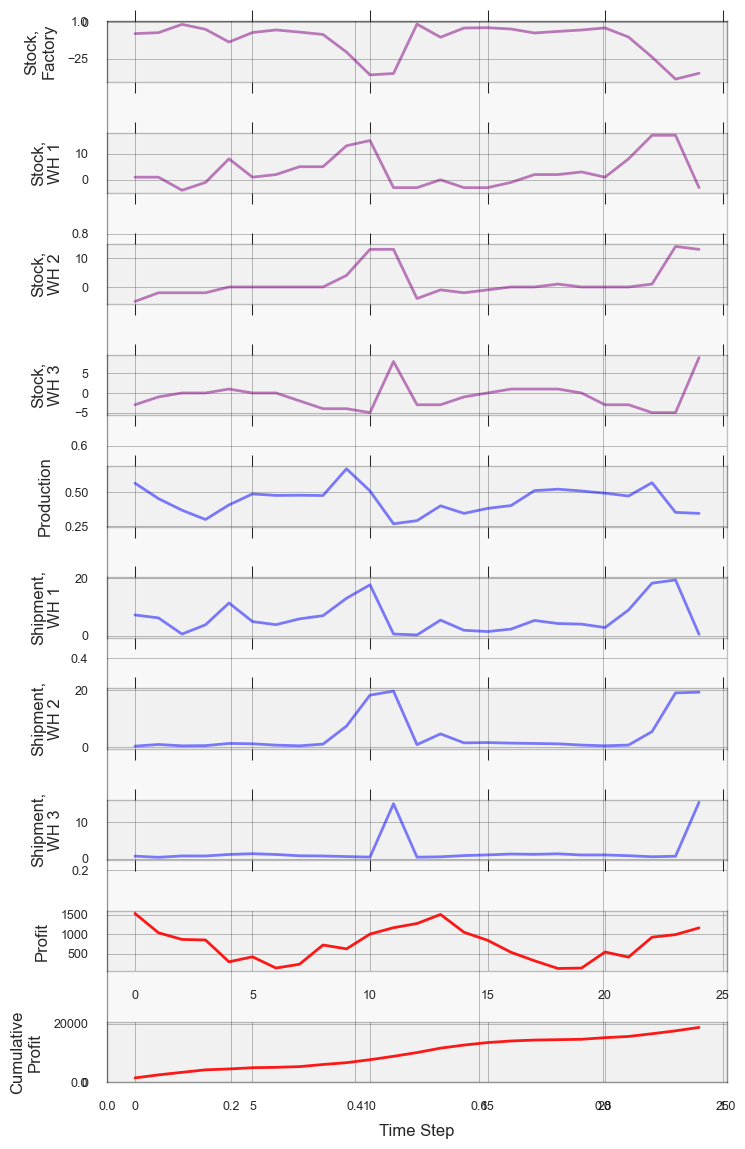

In [15]:
def visualize_transitions(transition_tuple):
    # Unpack the tuple of arrays.
    state_trace, action_trace, reward_trace = transition_tuple
    plots_n = 10
    plt.figure(figsize=(8, 12))
    print(f"Total Return: {np.sum(reward_trace)}")
 
    # Plot factory stock (assumed to be the first element of the state array).
    ax = plt.subplot(plots_n, 1, 1)
    ax.set_ylabel("Stock,\nFactory")
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)
    ax.plot(range(len(state_trace)), state_trace[:, 0], c='purple', alpha=0.5)
    
    # Assume the next few columns are warehouse stocks.
    # (Here we assume 3 warehouses; adjust if needed.)
    warehouse_num = 3
    for w in range(1, warehouse_num + 1):
        ax = plt.subplot(plots_n, 1, 1 + w)
        ax.set_ylabel(f"Stock,\nWH {w}")
        plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)
        ax.plot(range(len(state_trace)), state_trace[:, w], c='purple', alpha=0.5)
    
    # Plot production level from actions (assumed first element).
    ax = plt.subplot(plots_n, 1, 5)
    ax.set_ylabel("Production")
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)
    ax.plot(range(len(action_trace)), action_trace[:, 0], c='blue', alpha=0.5)
    
    # Plot shipments for each warehouse from actions (assumed remaining elements).
    for w in range(1, warehouse_num + 1):
        ax = plt.subplot(plots_n, 1, 5 + w)
        ax.set_ylabel(f"Shipment,\nWH {w}")
        plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)
        ax.plot(range(len(action_trace)), action_trace[:, w], c='blue', alpha=0.5)
    
    # Plot instantaneous rewards.
    ax = plt.subplot(plots_n, 1, 9)
    ax.set_ylabel("Profit")
    ax.plot(range(len(reward_trace)), reward_trace, c='red', alpha=0.9, linewidth=2)
    
    # Plot cumulative profit.
    ax = plt.subplot(plots_n, 1, 10)
    ax.set_ylabel("Cumulative\nProfit")
    ax.set_xlabel("Time Step")
    ax.set_ylim(0, np.sum(reward_trace) * 1.1)
    ax.plot(range(len(reward_trace)), np.cumsum(reward_trace), c='red', alpha=0.9, linewidth=2)
    
    plt.tight_layout()
    plt.show()

# Visualize the traced transitions.
visualize_transitions((state_trace, action_trace, reward_trace))